In [43]:
#Includes necesarios
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# KNN

Los hiperparametros que consideramos relevantes para un modelo como el de KNN (k-nearest neighbors) son:
   - n_neighbors (K): cantidad de vecinos, se aconseja que sea impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos
   - weights: El peso que se le da a la distancia entre los puntos.
   - metric: La funcion para calcular la distancia entre los puntos.

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [44]:
X,y = get_train_set()
X = pr.init_dataset(X)

## Preprocesamiento 1: OHE

Primero vamos a entrenar nuestro modelo KNN aplicando unicamente OHE a las columnas categoricas:

In [45]:
pr.init_OHE(X)
X_ohe = pr.apply_OHE(X)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [46]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe, y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para knn con GridSearchCV. 

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El numero de vecinos es impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos

In [47]:
parameters = {
    'n_neighbors': [43,101,151,199,251,307],
    'weights': ['uniform','distance'],
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.8930676256014902
Best params {'n_neighbors': 43, 'weights': 'uniform'}
------------------
Score in Validation: 0.9001246492024515


Armamos el modelo de KNN con los hiperparametros calculados:

In [48]:
model_knn = gscv.best_estimator_
model_knn

KNeighborsClassifier(n_neighbors=43)

Predecimos con el validation set:

In [49]:
knn_predict = model_knn.predict(X_validation)

**Metricas**

In [50]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.88      0.94      0.90      4945
           1       0.74      0.58      0.65      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.84      0.85      0.84      6513



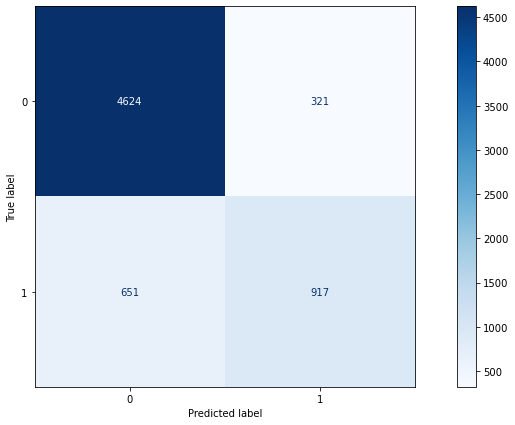

In [51]:
plot_cm(model_knn, X_validation, y_validation)

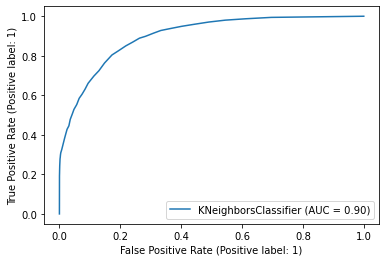

In [52]:
plot_roc_curve(model_knn, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 2: OHE + Estandarizacion 

Probaremos ahora como es el rendimiento del modelo KNN aplicando el mismo preprocesamiento y una estandarizacion. Para esto reutilizaremos **X_ohe** que es el resultado de haber aplicado OHE.

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento. Realizamos este primer paso ya que queremos evitar un dataleaking a causa que estamos calculando media y desviacion estandar con los datos de validacion:

In [53]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, stratify=y, random_state=0)

In [54]:
X_train = pr.standarize(X_train)
X_validation = pr.standarize(X_validation)

Buscamos los mejores hiperparametros para knn con GridSearchCV. 

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El numero de vecinos es impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos

In [55]:
parameters = {
    'n_neighbors': [43,101,151,199,251,307],
    'weights': ['uniform','distance'],
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True,verbose=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: 0.8762733676620709
Best params {'n_neighbors': 43, 'weights': 'uniform'}
------------------
Score in Validation: 0.8704366010812818


Armamos el modelo de KNN con los hiperparametros calculados:

In [56]:
model_knn_standar = gscv.best_estimator_
model_knn_standar

KNeighborsClassifier(n_neighbors=43)

Predecimos con el validation set:

In [57]:
knn_predict = model_knn_standar.predict(X_validation)

**Metricas**

In [58]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4945
           1       0.68      0.53      0.60      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.73      0.74      6513
weighted avg       0.82      0.83      0.82      6513



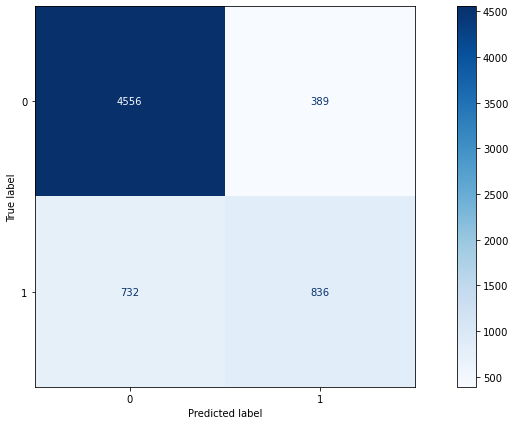

In [59]:
plot_cm(model_knn_standar, X_validation, y_validation)

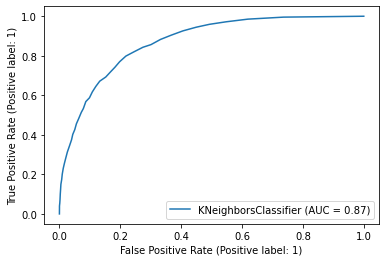

In [60]:
plot_roc_curve(model_knn_standar, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 3: OHE + Escalado 

Probaremos ahora como es el rendimiento del modelo KNN aplicando el mismo preprocesamiento y un escalado de nuestras columnas. El rango de escalado es entre (0,1). Para esto reutilizaremos **X_ohe** que es el resultado de haber aplicado OHE.

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento. Realizamos este primer paso ya que queremos evitar un dataleaking a causa que estamos calculando media y desviacion estandar con los datos de validacion:

In [61]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, stratify=y, random_state=0)

In [62]:
X_train = pr.scale(X_train)
X_validation = pr.scale(X_validation)

Buscamos los mejores hiperparametros para knn con GridSearchCV. 

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El numero de vecinos es impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos

In [63]:
parameters = {
    'n_neighbors': [43,101,151,199,251,307],
    'weights': ['uniform','distance'],
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True,verbose=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: 0.8795697459377643
Best params {'n_neighbors': 43, 'weights': 'uniform'}
------------------
Score in Validation: 0.8744367893770248


Armamos el modelo de KNN con los hiperparametros calculados:

In [64]:
model_knn_scale = gscv.best_estimator_
model_knn_scale

KNeighborsClassifier(n_neighbors=43)

Predecimos con el validation set:

In [65]:
knn_predict = model_knn_scale.predict(X_validation)

**Metricas**

In [66]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4945
           1       0.66      0.57      0.61      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.74      0.75      6513
weighted avg       0.82      0.83      0.82      6513



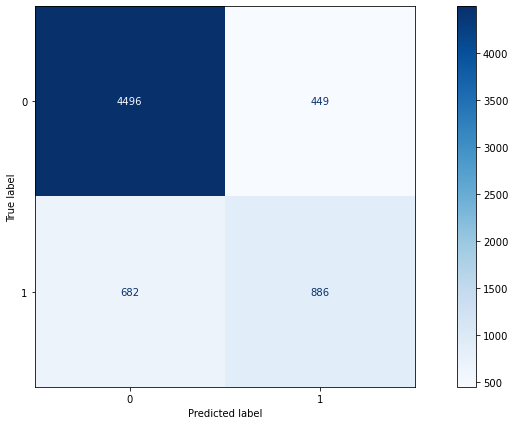

In [67]:
plot_cm(model_knn_scale, X_validation, y_validation)

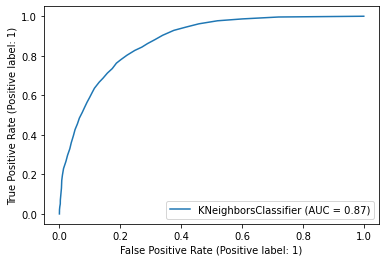

In [68]:
plot_roc_curve(model_knn_scale, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 4: OHE + Normalizacion

Probaremos ahora como es el rendimiento del modelo KNN aplicando el mismo preprocesamiento y una normalizacion.Para esto reutilizaremos **X_ohe** que es el resultado de haber aplicado OHE.

In [69]:
X_normalized = pr.normalize(X_ohe)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento. En el caso de la normalizacion, no hace falta realizar la particion antes debido a que se hace el calulo por filas y asi no se tiene dataleaking:

In [70]:
X_train, X_validation, y_train, y_validation = train_test_split(X_normalized,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para knn con GridSearchCV. 

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El numero de vecinos es impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos

In [71]:
parameters = {
    'n_neighbors': [43,101,151,199,251,307],
    'weights': ['uniform','distance']
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True,verbose=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: 0.8678822469885921
Best params {'n_neighbors': 43, 'weights': 'uniform'}
------------------
Score in Validation: 0.8644236473659231


Armamos el modelo de KNN con los hiperparametros calculados:

In [72]:
model_knn_normalized = gscv.best_estimator_
model_knn_normalized

KNeighborsClassifier(n_neighbors=43)

Predecimos con el validation set:

In [73]:
knn_predict = model_knn_normalized.predict(X_validation)

**Metricas**

In [74]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4945
           1       0.64      0.58      0.61      1568

    accuracy                           0.82      6513
   macro avg       0.75      0.74      0.74      6513
weighted avg       0.81      0.82      0.82      6513



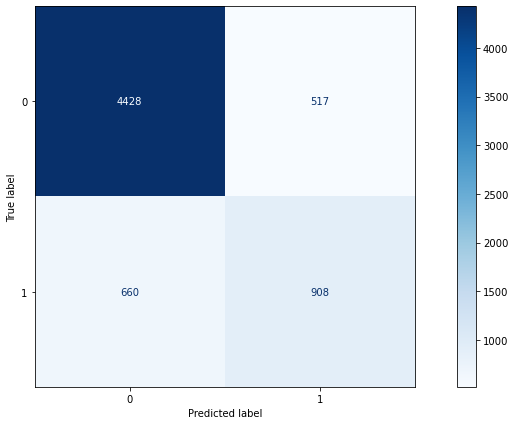

In [75]:
plot_cm(model_knn_normalized, X_validation, y_validation)

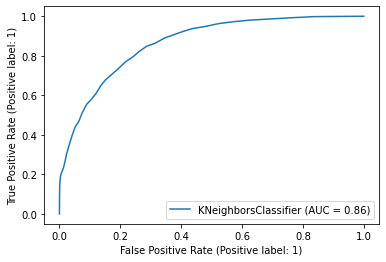

In [76]:
plot_roc_curve(model_knn_normalized, X_validation, y_validation, response_method="predict_proba")
plt.show()

# Conclusión

Vimos que aplicando unicamente OHE a nuestras columnas categoricas obtenemos el mejor resultado de la metrica *auc_roc* para este modelo. Aplicando estandarizacion, escalado o normalizacion producen una perdida de performance para la metrica *auc_roc*. Por ultimo, no es aconsejable este modelo para el dataset que se nos provee debido a que el entrenamiento del mismo crece significativamente con la cantidad de muestras del dataset.

# Predicción

In [77]:
ids, X_holdout = get_holdout_set()
X_holdout = pr.init_dataset(X_holdout)

In [78]:
pr.init_OHE(X)
X_holdout_ohe = pr.apply_OHE(X_holdout)

In [79]:
knn_predict = model_knn.predict(X_holdout_ohe)

In [80]:
create_prediction(ids,knn_predict,file_name='knn')